# Clustering evaluation on high dimensional data using graph clustering

The idea here is to start with a very small value of k for the kNN graph and expand according to boundary situation.

In [1]:
!git branch

* master


In [100]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

from partition_igraph import community_ecg as ecg
from community import community_louvain, modularity
import leidenalg as la
import igraph as ig

sns.set()

# MNIST, USPS and Pendigits are easy

We can use the sklearn API to fetch data for the Pendigits, MNIST and USPS datasets.

Of these datasets pendigits is the smallest, with only 1797 samples, and is only 64 dimensional. This makes a good first dataset to test things out on -- the dataset is small enough that practically anything should be able to run on this efficiently.

USPS provides a slightly more challenging dataset, with almost 10,000 samples and 256 dimensions, but is still samall enough to be tractable for even naive clustering implementations.

MNIST provides a good basic scaling test with 70,000 samples in 784 dimensions. In practice this is not a very large dataset compared to many that people want to cluster, although the dimensionality may provide some challenges.

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [50]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [ ]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

# Compare graph algorithms performance on different graph constructions

In [12]:
dataset_id = 0

In [41]:
raw_data, targets, dataset_name = get_dataset(dataset_id)
display(Markdown(f'## {dataset_name}'))

# Graph from fuzzy union
# G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1)
G_big = knn_digraph(raw_data, k=50)
G = knn_digraph(raw_data, k=3)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

## pendigits

In [42]:
clusterings = la.find_partition(G, la.ModularityVertexPartition).membership
G = graph_edge_class_from_labels(G, clusterings, attribute_name = 'in_cluster')

In [43]:
sum([(e['in_cluster'])&(not e['internal']) for e in G.es])

70

In [34]:
max(clusterings)

47

In [122]:
new_params = get_dataset_params(dataset_id).copy()
new_params['n_neighbors'] = 30

In [123]:
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1, params=new_params)

(array([15596.,  8399.,  3581.,  1950.,  1197.,   822.,   617.,   433.,
          375.,  1676.]),
 array([1.08346094e-05, 1.00009754e-01, 2.00008661e-01, 3.00007582e-01,
        4.00006503e-01, 5.00005424e-01, 6.00004315e-01, 7.00003266e-01,
        8.00002158e-01, 9.00001109e-01, 1.00000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

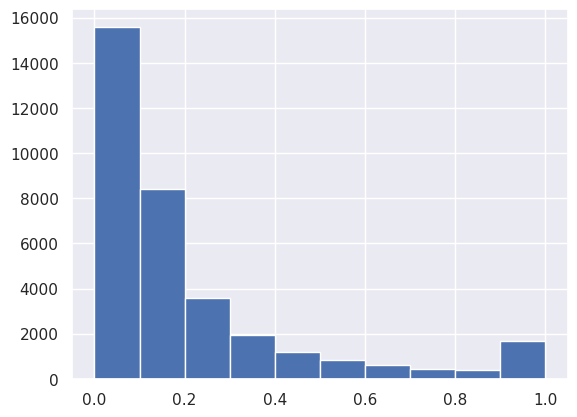

In [124]:
plt.hist(G.es['weight'])

In [104]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
ari = adjusted_rand_score(targets, hd_umap_labels)
print(ari)

0.9185149200427103


In [170]:
def cluster_threshold_graph(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))

    new_params = get_dataset_params(dataset_id).copy()
    new_params['n_neighbors'] = int(1.5*new_params['n_neighbors'])
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=1, params=new_params)

    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    ari = adjusted_rand_score(targets[hd_umap_labels!=-1], hd_umap_labels[hd_umap_labels!=-1])

    clustering_labels = dict()
    for t in np.arange(-0.003, 0.3, 0.01):
        edge_seq_to_delete = [e for e in G.es if e['weight']<=t]
        sub_G = G.copy()
        sub_G.delete_edges(edge_seq_to_delete)
        clusterings = np.array(la.find_partition(sub_G, la.ModularityVertexPartition).membership)
        clustering_labels[t] = clusterings

    graph_results = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results = graph_results.rename(columns={'Method':'Threshold'})
    graph_results['Baseline'] = ari
    graph_results['Dataset'] = dataset_name
    return(graph_results)

In [171]:
res = []
for i in range(5):
    res.append(cluster_threshold_graph(dataset_id=i))
graph_results = pd.concat(res)

## pendigits

## coil

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


## mnist

## usps

## buildings

In [175]:
graph_results[graph_results.Dataset != 'pendigits']

,Threshold,ARI,AMI,Silhouette,Pct Clustered,Baseline,Dataset
0,-0.003,0.808632,0.893562,0.193468,1.000000,0.795765,coil
1,0.007,0.799342,0.894210,0.179825,1.000000,0.795765,coil
2,0.017,0.811010,0.894555,0.193311,1.000000,0.795765,coil
3,0.027,0.811010,0.894555,0.193311,1.000000,0.795765,coil
4,0.037,0.811675,0.895839,0.195068,1.000000,0.795765,coil
...,...,...,...,...,...,...,...
26,0.257,0.350200,0.670951,0.015406,1.000000,0.314669,buildings
27,0.267,0.363594,0.681206,0.019029,1.000000,0.314669,buildings
28,0.277,0.371183,0.688592,0.012794,1.000000,0.314669,buildings
29,0.287,0.369634,0.689426,0.017530,1.000000,0.314669,buildings


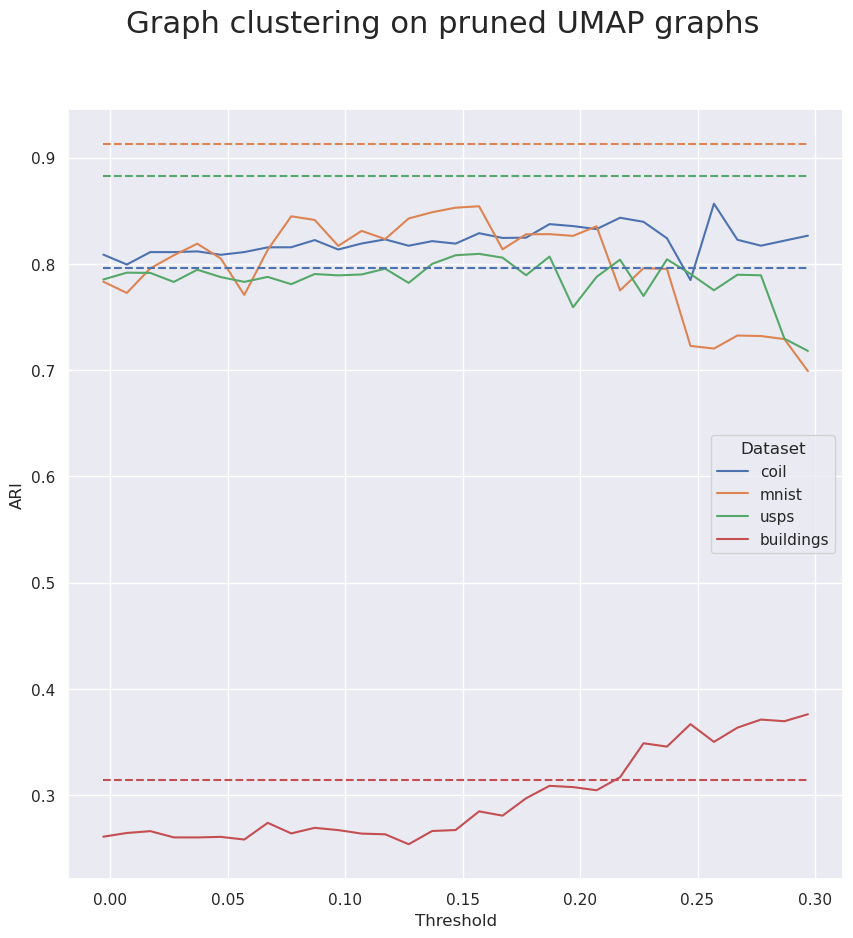

In [176]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Graph clustering on pruned UMAP graphs', fontsize=22)
ax = sns.lineplot(data=graph_results[graph_results.Dataset != 'pendigits'], x='Threshold', y='ARI', hue='Dataset')
ax = sns.lineplot(data=graph_results[graph_results.Dataset != 'pendigits'], x='Threshold', y='Baseline', hue='Dataset', legend=None, linestyle='--')
plt.savefig(f'figures/thresholded_graph_clustering_umap_weight.png')

In [181]:

# Romeo and Juliet: each edge weights is replaced by the average of weights (including 0-weight)
# between the two endpoints' neighborhoods. If a node appears in both neiborhoods, we "clone"
# it and add an edge of weight 1 between the node and itself.
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

def get_triangle_similarity(A_w):
    # Make the matrix binary
    A = 1*(A_w!=0)
    # Count number of triangles in which each pair of node is involved
    counts = A.multiply(A*A)
    
    C = dict()
    N = max(counts.data)
    for n in range(1,N+1):
        C[n] = (counts==n)*n
    D = C[2]/N
    for n in range(3,N+1):
        D += C[n]/N
        
    return(D)


In [164]:
dataset_id = 4

k = get_dataset_params(dataset_id)['n_neighbors']
A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                 n_neighbors=int(1.2*k), 
                                                 random_state=0, 
                                                 metric='euclidean', 
                                                 return_dists=True,
                                                 set_op_mix_ratio=1)

W = neighborhood_amplification(A_umap)
G = ig.Graph.Weighted_Adjacency(W, 'undirected')

(array([ 317., 1909., 2439., 1491., 1017.,  677.,  466., 1153.,  417.,
          43.]),
 array([0.04678022, 0.12007164, 0.19336306, 0.26665448, 0.3399459 ,
        0.41323732, 0.48652874, 0.55982016, 0.63311157, 0.70640299,
        0.77969441]),
 <BarContainer object of 10 artists>)

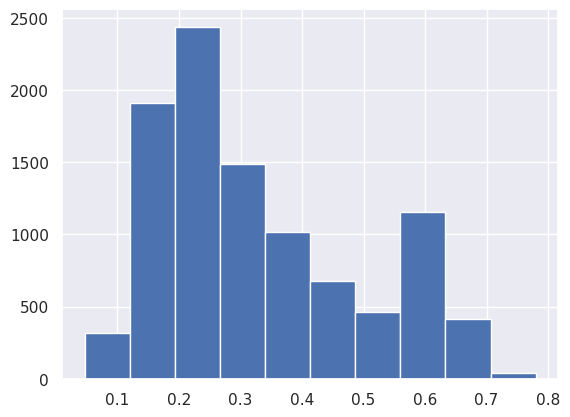

In [165]:
plt.hist(G.es['weight'])

In [167]:
def cluster_threshold_similarity(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))

    k = get_dataset_params(dataset_id)['n_neighbors']
    A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                     n_neighbors=int(1.2*k), 
                                                     random_state=0, 
                                                     metric='euclidean', 
                                                     return_dists=True,
                                                     set_op_mix_ratio=1)

    W = neighborhood_amplification(A_umap)
    G = ig.Graph.Weighted_Adjacency(W, 'undirected')

    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    ari = adjusted_rand_score(targets, hd_umap_labels)

    clustering_labels = dict()
    for t in np.arange(-0.003, 0.25, 0.005):
        edge_seq_to_delete = [e for e in G.es if e['weight']<=t]
        sub_G = G.copy()
        sub_G.delete_edges(edge_seq_to_delete)
        clusterings = np.array(la.find_partition(sub_G, la.ModularityVertexPartition).membership)
        clustering_labels[t] = clusterings

    graph_results = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results = graph_results.rename(columns={'Method':'Threshold'})
    graph_results['Baseline'] = ari
    graph_results['Dataset'] = dataset_name
    return(graph_results)

In [168]:
res = []
for i in range(5):
    res.append(cluster_threshold_similarity(dataset_id=i))
graph_results_2 = pd.concat(res)

## pendigits

## coil

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


## mnist

## usps

## buildings

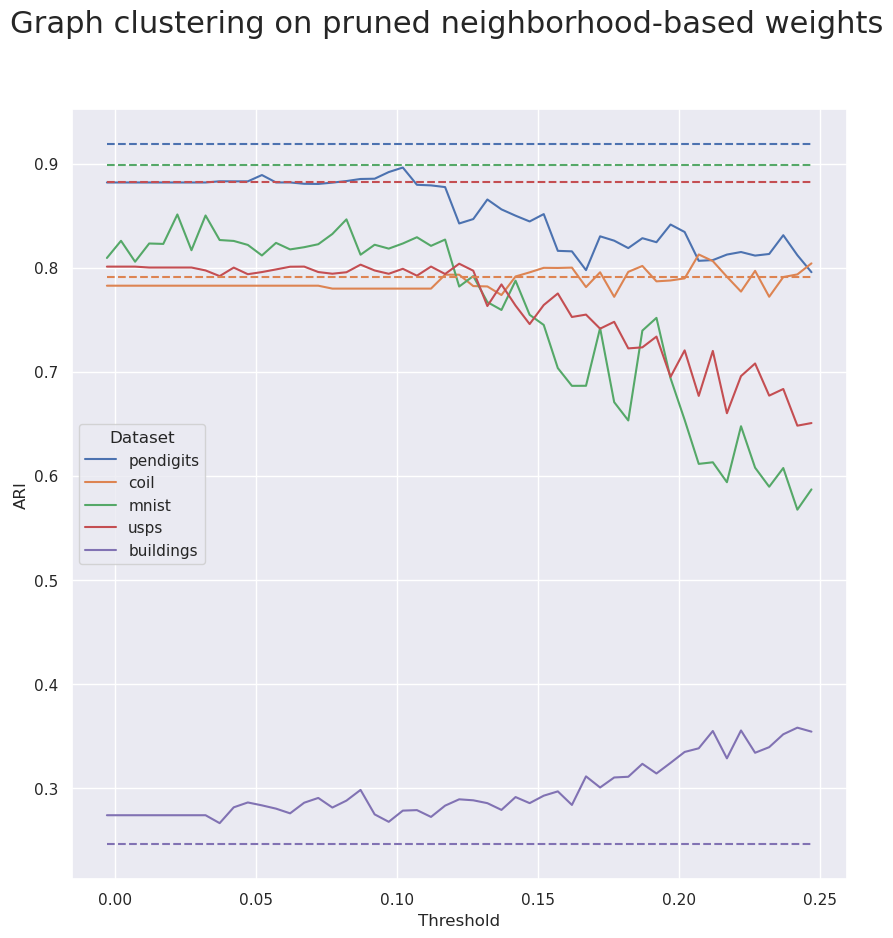

In [169]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Graph clustering on pruned neighborhood-based weights', fontsize=22)
ax = sns.lineplot(data=graph_results_2, x='Threshold', y='ARI', hue='Dataset')
ax = sns.lineplot(data=graph_results_2, x='Threshold', y='Baseline', hue='Dataset', legend=None, linestyle='--')
plt.savefig(f'figures/thresholded_graph_clustering_romeo_weight.png')

In [187]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [190]:
sns.set_style(style='white') 

In [182]:
raw_data, targets, dataset_name = get_dataset(dataset_id=0)
display(Markdown(f'## {dataset_name}'))

## pendigits

In [183]:
tsne_map = TSNE().fit_transform(raw_data)

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [184]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(raw_data, n_neighbors=15, metric="euclidean", random_state=42)

In [185]:
def plot_graph_data(adjacency_csr, layout, node_labels):
    fig, ax = plt.subplots(figsize=(12,12))
    coo_umap_graph = adjacency_csr.tocoo()
    edges = LineCollection(
        np.dstack([layout[coo_umap_graph.row], layout[coo_umap_graph.col]]).transpose((0, 2, 1)), 
        linewidths=0.5 * coo_umap_graph.data, 
        colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
        zorder=3
    )
    ax.add_collection(edges)
    # for idx in range(coo_umap_graph.row.shape[0]):
    #     i, j, weight = coo_umap_graph.row[idx], coo_umap_graph.col[idx], coo_umap_graph.data[idx]
    #     ax.plot(map.T[0][[i, j]], map.T[1][[i, j]], lw=weight*0.5, c='k', alpha=weight)
    ax.scatter(*layout.T, s=5, c=node_labels, cmap="Spectral")
    return(fig)

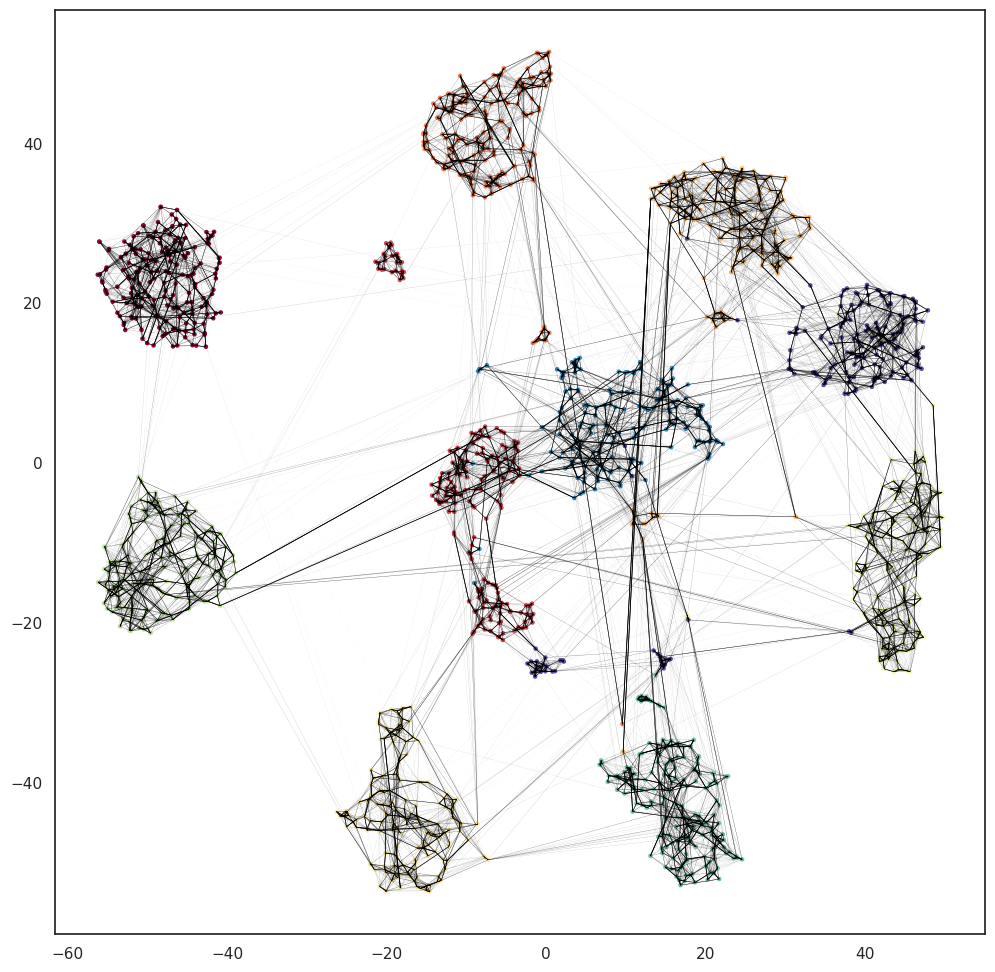

In [191]:
test = plot_graph_data(symmetric_graph, tsne_map, targets)